<a href="https://colab.research.google.com/github/DiegoPascualAntolinos/IC/blob/master/P2_Adaboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Práctica 2 de Sistemas Inteligentes.

 Clasificación de imagenes fashion-MNIST mediante AdaBoost.
 
* La forma más sencilla de clasificar objetos distribuidos en un espacio es dividir el espacio en dos partes y especificar que los objetos que quedan a un lado se van a clasificar según una clase y los objetos que quedan al otro lado según la otra clase. Esto es posible realizarlo de manera muy sencilla utilizando un umbral. Los umbrales pueden ser positivos o negativos y especifican para un determinado pixel (solo uno) el rango aceptable para el mismo. 

En este Notebook se incluye el código de Adaboost y la implementación de un clasificador débil de umbral. **Se debe implementar el clasificador de débil de hiperplanos y completar la sección de experimentación**.




Incluimos las librerias necesarias para obtener la base de datos, y realizar representaciones gráficas

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import os


In [0]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Observamos el tamaño de la libreria cargada. Utilizaremos solo las primeras 4000 imágenes para coincidir con la parte básica de la práctica 2 desarrollada en java

In [17]:
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

En google colab (jupyter notebook) es muy fácil poder visualizar gráficas e imágenes. Vamos a ver el segundo elemento del conjunto de entrenamiento:

(<matplotlib.image.AxesImage at 0x7facbc8b3470>, 0)

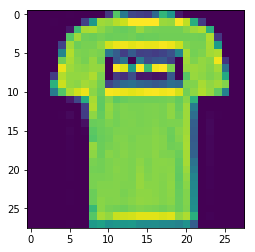

In [18]:
plt.imshow(x_train[1]),y_train[1]

# Algoritmo Adaboost
A continuación se presenta una implementación del algoritmo Adaboost

In [0]:
def adaboost(X,Y,T,random_trainer_iterations,weak_generator,weak_error):
    
    N = len(X)
    h = np.zeros([T, 3], dtype=np.double)
    alpha = np.zeros(T, dtype=np.double)
    err = np.ones(T, dtype=np.double) * np.inf
    
    #Distribución inicialmente uniforme
    D = np.ones(N, dtype=np.double)/N  
    
    for i in range(T):
        for rti in range(random_trainer_iterations):
            h_tmp = weak_generator();
            [err_tmp,y_tmp] = weak_error(h_tmp,X,Y,D)
            if(err_tmp<err[i]):
                h[i] = h_tmp
                err[i] = err_tmp
                y_t = y_tmp
            
        
        alpha[i] = 0.5 * np.log((1.0 - err[i]) / err[i])
        y_t[np.where(y_t == 0)] = -1 # y_t contiene 1 en los errores 
                                     #y -1 el los aciertos, por lo que cambiare...
        
        # .. el signo de y_t (se podria cambiar solo el de alpha)
        D = np.double(D * np.exp(-alpha[i] * -y_t))  
       
        D = D/np.sum(D)  # Normalise reassigned weights
        
    return [h,alpha]   

A continuación se presenta el clasificador fuerte que se obtendrá a partir de Adaboost

In [0]:
def strong_classify_image(classifier,weak_apply, X):
    [h,alpha] = classifier
    N = len(X)
        
    fuerte = []
    for i in range(len(alpha)):
        h_res = weak_apply(h[i],X)
        if (i==0):
            fuerte = np.double(alpha[i] * h_res)
        else:
            fuerte = fuerte + np.double(alpha[i] * h_res)
        #from IPython.core.debugger import Tracer; Tracer()()
        
    f = np.sign(fuerte)
    return f
        
    

## Definición de los clasificadores débiles como umbral para un pixel de la imagen

In [0]:
def generate_weak_threshold():
    ht = np.zeros(3)
    ht[0] = np.random.randint(28*28) #Pos. Img.
    ht[1] = np.random.rand(1)*256    #Valor
    ht[2] = np.sign(np.random.rand(1)*2-1)  #Direccion umbral
    return ht;

def apply_weak_threshold(ht,X):
    k = int(ht[0])
    if(ht[-1]>0):
        t = X[:,k]>ht[1]
    else: 
        t = X[:,k]<=ht[1]
    
    #Verifico que las condiciones se cumplan en todas las
    #dimensiones (true si cumple, false si no)
    t_all = np.int16(t)
    t_all[np.where(t_all == 0)] = -1
    
    return t_all

def error_weak_threshold(ht,X,Y,D=1):
    k = int(ht[0])
    if(ht[-1]>0):
        t = X[:,k]>ht[1]
    else: 
        t = X[:,k]<=ht[1]
        
    
    #Verifico que las condiciones se cumplan en todas las dimensiones 
    # (true si cumple, false si no)
    t_all = np.int16(t)
    t_all[np.where(t_all == 0)] = -1
    
    #Obtengo el error con respecto a Y
    errv = np.int64(t_all != Y)
    errs = np.sum(errv * D)
    
    return [errs,errv]

In [22]:
ht = generate_weak_threshold()
ht

array([237.        , 129.52331333,  -1.        ])

## Definición de los clasificadores débiles como plano
Para hacer por el alumnado

In [0]:
import random

def generateVector():#funcion que genera un array de 28*28 que contiene numero de 0 a 255
  vector = []
  for i in range(28*28):
    rand = random.randint(0,255)
    vector.append(rand)
  return(vector)

def generateOnes():#funcion que genera un array de 28*28 que contiene 1s y -1s
  vector = []
  for i in range(28*28):
    rand = random.randint(-1,1)
    if rand == 0:
      rand = -1      
    vector.append(rand)
  return(vector)
  
def generateHiperplane():#Funcion que genera un hiperplano
  C = 0.0
  vectorUnos = generateOnes() #Generamos el vector de tamaño 28*28 de 1s y -1s aleatorios
  vector = generateVector() #Generamos el vector de tamaño 28*28 de 0 a 255 aleatorios
  
  for i in range(28*28):
    C += vectorUnos[i] * vector[i] #Calculamos C
  
  hiperplano = [vectorUnos, vector, C] #[ 1s y -1s, 0 - 255, termino libre C]
  
  ht = np.zeros((28*28, 3))# Creamos un array
  for i in range(28*28):
    ht[i,0] = hiperplano[0][i]
    ht[i,1] = hiperplano[1][i]
    ht[i,2] = hiperplano[2]
    
  print(ht)
  
  return ht

def compruebaPos(imagen, hiperplano):#Funcion que comprueba la posición de una imagen con respecto a un hiperplano
  res = 0.0 #Inicializamos el resultado a 0
  pos = 0 # POsicion de la imagen con respecto al
  
  for i in range(len(imagen)):
    res += hiperplano[0][i] * imagen[i]
  pos = res - hiperplano[3]#calculamos la posicion restandole el termino libre C al resultado obtenido anteriormente
  
  if pos < 0 :
    return -1
  else:
    return 1

def numErroresHiperplano(hiperplano, imagenes, tipo, D=1): #Dada una serie de imagenes, un hiperplano y un tipo devuelve la cantidad de errores cometidos por el hiperplano
  cantErrores = 0 
  
  for i in range(len(imagenes)):
    res = compruebaPos(imagenes[i], hiperplano) # Comprobamos de qué tipo nos dice el hiperplano que es la imagen que le pasamos
    if res != tipo: # Si el resultado fuera distinto al tipo que verdaderamente es la imagen
      cantErrores += 1 # Aumentamos el error
  
  
  errs = np.sum(cantErrores * D)
    
  return [errs,cantErrores]
  
  
  


# Entrenamiento para las primeras 4000 imágenes
Obtengo un clasificador fuerte por conjunto. En esta implementación se gastan las 10 clases de la base de datos al completo (no las 8 que se gastan en la práctica de Java), con lo que los resultados pueden variar sobre esta. Es sencillo utilizar los mismos conjuntos de la implementación java si se desea...

In [38]:
num_samples = 4000
f = []
for i in range(7):
    Y = np.zeros(num_samples)
    v_digit = y_train[0:num_samples]==i
    v_else = y_train[0:num_samples]!=i
    Y[v_digit] = 1
    Y[v_else] = -1
    X = x_train[0:num_samples].reshape(num_samples,28*28)
    
    #Obtengo el clasificador fuerte para el conjunto i
    #f.append(adaboost(X,Y,100,1000,generate_weak_threshold,error_weak_threshold))
    f.append(adaboost(X,Y,100,1000,generateHiperplane(),numErroresHiperplano))
    print(".")

[[-1.0000e+00  4.1000e+01 -4.2164e+04]
 [ 1.0000e+00  2.3900e+02 -4.2164e+04]
 [-1.0000e+00  1.0000e+01 -4.2164e+04]
 ...
 [-1.0000e+00  1.7200e+02 -4.2164e+04]
 [-1.0000e+00  1.9800e+02 -4.2164e+04]
 [-1.0000e+00  2.0000e+01 -4.2164e+04]]


TypeError: ignored

Aplico el clasificador fuerte a todas las imágenes y obtengo el conjunto de clasificación

In [0]:
num_samples = 60000
r = []
for i in range(7):
    Y = np.zeros(num_samples)
    v_digit = y_train[0:num_samples]==i
    v_else = y_train[0:num_samples]!=i
    Y[v_digit] = 1
    Y[v_else] = -1
    X = x_train[0:num_samples].reshape(num_samples,28*28)
    r.append(strong_classify_image(f[i],apply_weak_threshold,X))

In [0]:
r_all = np.vstack([r[0],r[1],r[2],r[3],r[4],r[5],r[6]])#,r[7],r[8],r[9]])
r_all.shape

(7, 60000)

Transformo el vector de -1 y 1 a conjunto

In [0]:
r_digits = []
for i in range(r_all.shape[1]):
    td = np.where(r_all[:,i]==1)
    if(td[0].size==0):
        rd = -1
    else:
        rd = td[0][0]
    r_digits.append(rd)

r_digits = np.asarray(r_digits)

In [0]:
r_digits

array([-1,  0,  0, ...,  3,  0,  5])

Y obtengo la tasa de aciertos

In [0]:
Y_d = y_train[0:num_samples]
correct_digits = Y_d == r_digits
np.sum(correct_digits)/(num_samples*1.0)

0.47673333333333334

Creamos una gráfica donde almacenaremos los datos

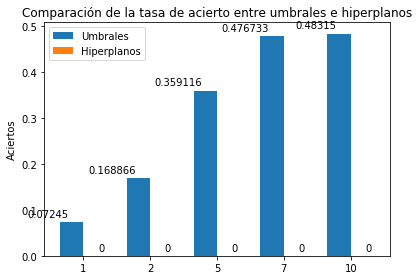

In [39]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


men_means, men_std = (0.07245, 0.168866, 0.359116, 0.476733, 0.483150), (0,0,0,0,0)
women_means, women_std = (0, 0, 0, 0, 0), (0,0,0,0,0)

ind = np.arange(len(men_means))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, men_means, width, yerr=men_std,
                label='Umbrales')
rects2 = ax.bar(ind + width/2, women_means, width, yerr=women_std,
                label='Hiperplanos')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Aciertos')
ax.set_title('Comparación de la tasa de acierto entre umbrales e hiperplanos')
ax.set_xticks(ind)
ax.set_xticklabels(('1', '2', '5', '7', '10'))
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

plt.show()

# Experimentación
Para hacer por el alumnado. Se valorará el uso de gráficas mediante *matplotlib*
## Hiperplano
### Obtener tasa de aciertos para un dígito 
### Obtener tasa de aciertos para varios dígitos
## Umbral
### Obtener tasa de aciertos para un dígito -> 0.07245
![texto alternativo](https://i.imgur.com/BqlE4AW.png)
![texto alternativo](https://i.imgur.com/LlCT8HY.png)

### Obtener tasa de aciertos para varios dígitos
### 2 dígitos
![texto alternativo](https://i.imgur.com/Ke5Ra6m.png)
![texto alternativo](https://i.imgur.com/Au2lYHW.png)

### 5 dígitos
![texto alternativo](https://i.imgur.com/2BQQ3UP.png)
![texto alternativo](https://i.imgur.com/eY2FudB.png)

### 7 dígitos
![texto alternativo](https://i.imgur.com/KF5njDw.png)
![texto alternativo](https://i.imgur.com/LoKO79e.png)

### 10 dígitos
![texto alternativo](https://i.imgur.com/CtJTP74.png)
![texto alternativo](https://i.imgur.com/POR5OPP.png)

## Comparación hiperplano vs umbral

## Otras métricas